# 自然语言处理-词向量模型-Word2Vec

## 1.向量化

### 1.1向量化进行替代

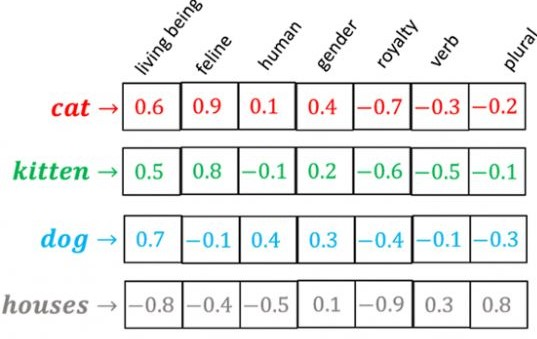

对每一个单词都有各自唯一对应的向量，向量可以基本描述单词所需要传递出的所有信息

### 1.2向量化进行对比

①计算向量之间的余弦值比较相似度

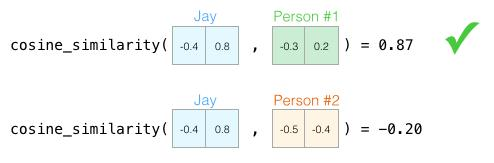

②用热度图可更加值观比较

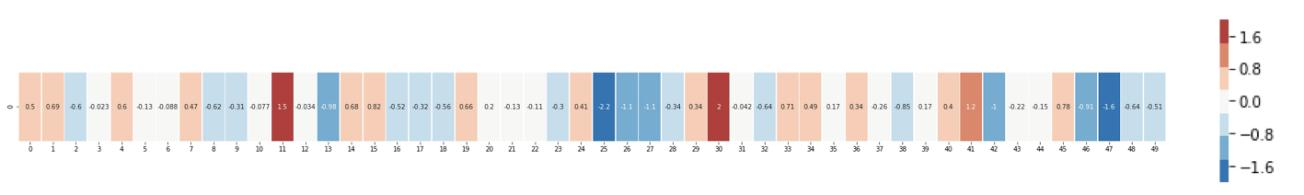

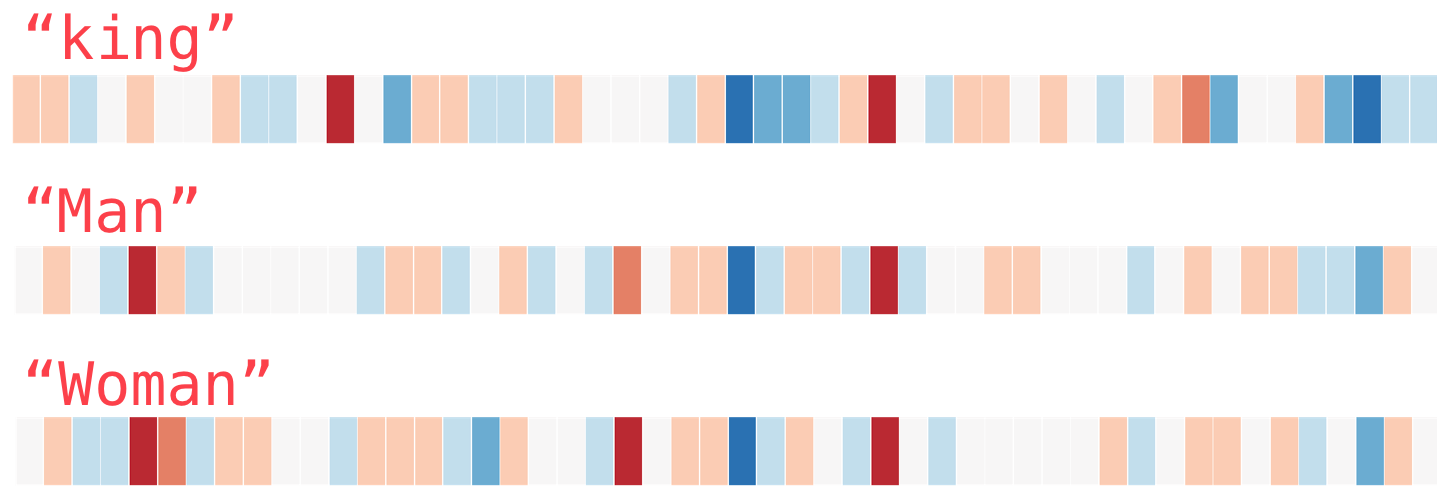

## 2.自然语言处理

### 2.1词嵌入

源问题：计算机处理自然语言

解决方式：将词语转化为向量，将整个文本分散嵌入到另一个离散空间。

### 2.2One Hot向量

定义：一个只含有一个1，其他都是0的向量，所有的One Hot向量共同组成一个N维空间的向量基底。

特点：能够定义一个维度为N的有序词汇表，每个向量的维度也为N。

不足：指代词汇表里的词语时无法附带语义。

### 2.3Word2Vec模型

模型出处：

[《Distributed Representations ofWords and Phrases and their Compositionality》](https://arxiv.org/pdf/1310.4546.pdf)

[《Efficient Estimation of Word Representations in Vector Space》](http://xxx.itp.ac.cn/pdf/1301.3781v3)

语言学基础：具有相同上下文的单词之间倾向于具有相同的语义，例如下面两个句子：
#### 一只猫在房间跑来跑去
#### 一条狗在房间跑来跑去
猫和狗在句子中可能经常出现在相同的上下文中，因此可以利用某个词的上下文来预测这个词，反之也成立。

## 3.神经网络
### 3.1神经元模型
下图是一个典型的神经元模型：包含有3个输入，1个输出，以及2个计算功能。
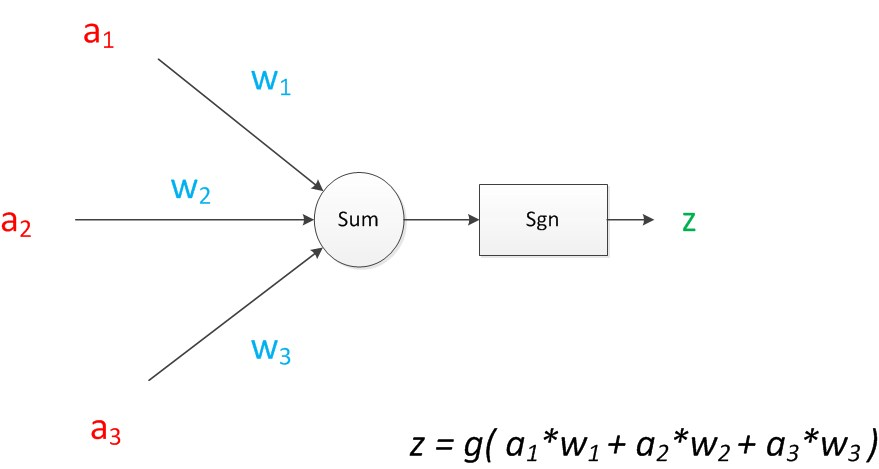
### 3.2神经网络模型

我们将输出增加到两个神经元z1和z2


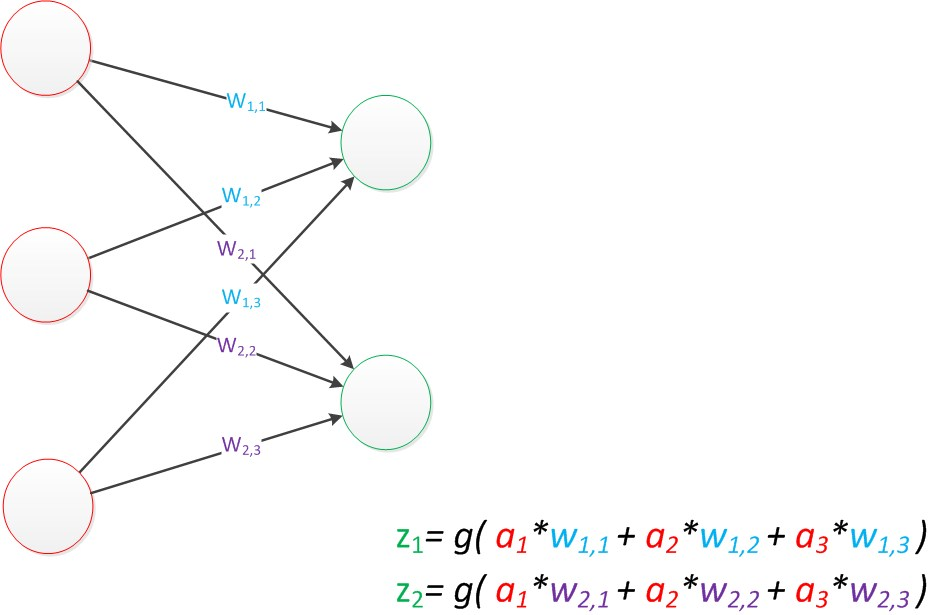


对权值w进行矩阵式命名为w_ij，我们发现，原来的神经网络两层之间的运算可以看成向量矩阵的乘法

一般的神经网络如下


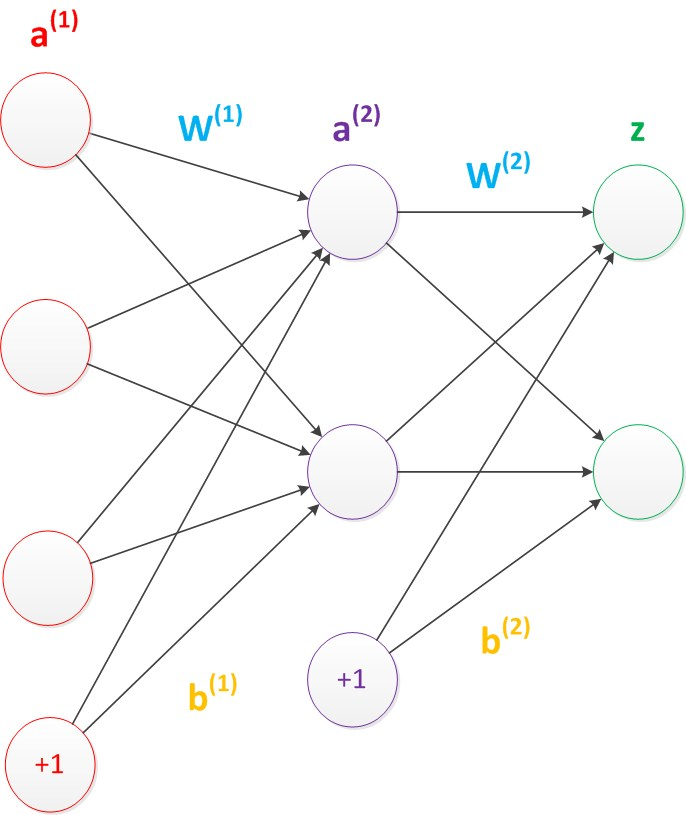


一般情况下，神经网络至少包括一个中间层，并往往会在每层之间增加了一偏置节点bi，相当于一个截距项，在矩阵向量乘法后加入了一个列向量

## 4.CBOW模型和Skip-Gram模型
### 4.1模型对比
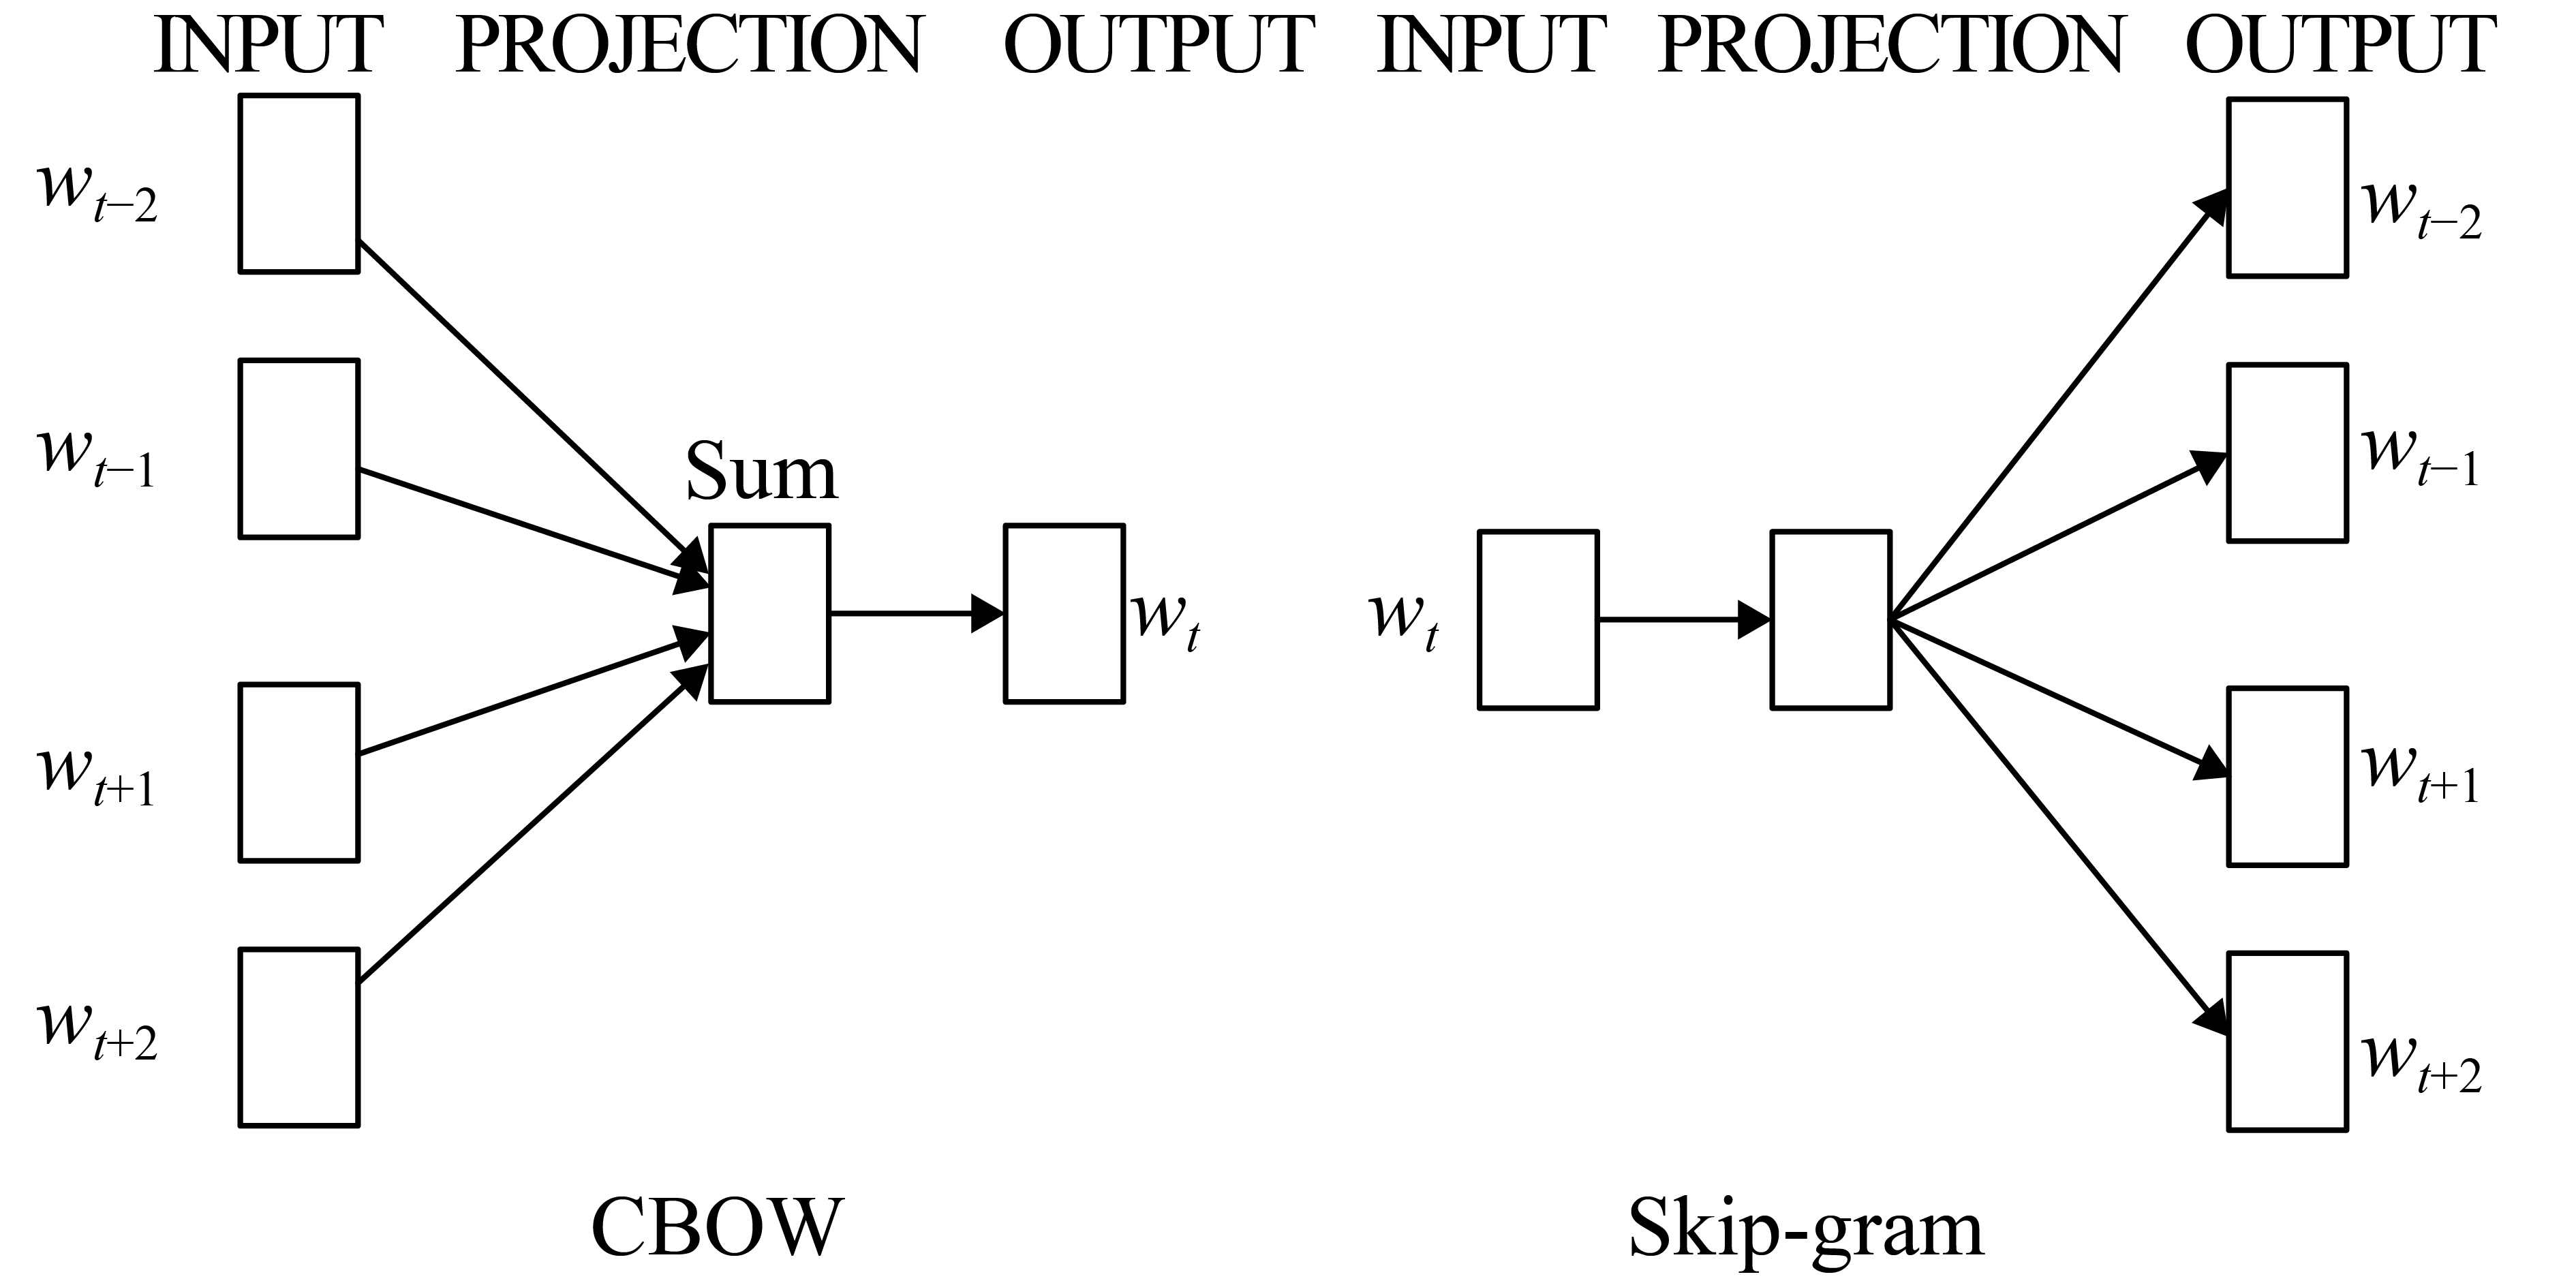
我们发现，CBOW是利用通过一个词的上下文来预测这个词的想法构建的；Skip-Gram则是利用通过一个词来预测它的上下文来构建的。

### 4.2原理分析
如下图，我们分析最简单的情形，即利用通过一个词的上文的一个单词来预测它构建CBOW模型，分析最后获得词向量的步骤。
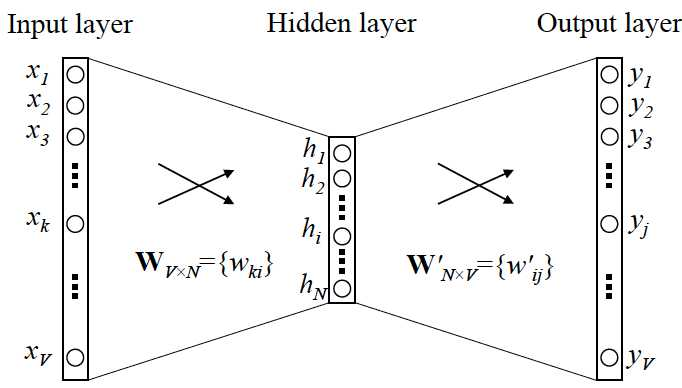
#### 4.2.1为词汇表构建One-Hot编码向量
假设词汇表有V个单词，那么就有V个V维的且相互独立的One-Hot向量，将一个词上文的最近的一个单词作为输入，One-Hot向量分别为：

$$X = (x_1,x_2,x_3,...,x_V)$$

$$T = (t_1,t_2,t_3,...,t_V)$$
$X$也即为上图输入层每个元素组成的向量。
#### 4.2.2输入层到隐藏层
根据神经网路计算方式，从输入层到隐藏层相当于One-Hot向量与权值矩阵相乘，得到隐藏层，也可以用向量$H$表示：
$$W·X = H$$
其中，$W$是一个$N*V$的矩阵，则得到的$H$是一个N维向量，我们要训练得到的词向量也是N维的。
#### 4.2.3隐藏层到输出层
从隐藏层到输出层，先是将向量$H$进行了同前面类似的运算：
$$W'·N = U$$
其中$W'$是隐藏层到输出层的$V*N$权值矩阵，得到$U$是一个V维分数向量。
然后对$U$进行softmax运算，将$U$中元素的值归一化，得到输出层向量$Y$，运算模式如下：
$$y_j = \frac{\sum_{k=1}^{V}{exp(u_k)}}{exp(u_j)}$$
#### 4.2.4训练模型
我们根据得到的参数$y_j$来构建损失函数，进而训练模型来不断更新权值矩阵$W$、$W'$，一般情况下，我们将最终获得的$W$的列向量作为词向量。
假设$y_j$对应被预测词（也可以视作成功预测的概率），则目标函数为：
$$OB = max(y_j)= max(log(y_j))= max(log(\frac{\sum_{k=1}^{V}{exp(u_k)}}{exp(u_j)})) = max(u_j-log(\sum_{k=1}^{V}{exp(u_k)}))$$
转换为损失函数：
$$Loss = -OB = -u_j+log(\sum_{k=1}^{V}{exp(u_k)})$$
$Loss$对$W'$中的$w'_{ij}$求偏导可以用来更新$W'$，$Loss$对$H$中的元素$h_i$求偏导来替代对$W$中的$w_{ji}$求偏导，用来更新$W$（因为$H$就是$W$里的列向量，并且和One-Hot向量一一对应。）
训练过程中采用反向传播来求解偏导数，采用梯度下降法更新权值矩阵元素，该方法在计算$W'$更新时十分繁琐(每更新一次矩阵又涉及到V个更新)且要处理的词汇表往往包含上万条单词，因此可以采用Hierarchical SoftMax（HS）和 Negative Sampling两种优化策略，在此不过多赘述。

## 5.代码实现（自行构建语料库）

In [11]:
#导入工具包
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import pandas as pd

Instructions for updating:
non-resource variables are not supported in the long term


In [33]:
#建立语料库
corpus = ['king is a strong man',
          'queen is a wise woman',
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong',
         'woman is pretty',
         'prince is a boy will be king',
         'princess is a girl will be queen']

#通过语料库建立词汇表
words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)
        
#将拆分后的句子含有的单词唯一化
words = set(words) 

In [34]:
words

{'a',
 'be',
 'boy',
 'girl',
 'is',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'will',
 'wise',
 'woman',
 'young'}

In [37]:
#为词汇进行编号
word2int = {}
for i,word in enumerate(words):
    word2int[word] = i
word2int

{'princess': 0,
 'a': 1,
 'king': 2,
 'man': 3,
 'is': 4,
 'will': 5,
 'wise': 6,
 'strong': 7,
 'young': 8,
 'girl': 9,
 'woman': 10,
 'prince': 11,
 'be': 12,
 'pretty': 13,
 'queen': 14,
 'boy': 15}

In [38]:
#拆分句子
sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
sentences

[['king', 'is', 'a', 'strong', 'man'],
 ['queen', 'is', 'a', 'wise', 'woman'],
 ['boy', 'is', 'a', 'young', 'man'],
 ['girl', 'is', 'a', 'young', 'woman'],
 ['prince', 'is', 'a', 'young', 'king'],
 ['princess', 'is', 'a', 'young', 'queen'],
 ['man', 'is', 'strong'],
 ['woman', 'is', 'pretty'],
 ['prince', 'is', 'a', 'boy', 'will', 'be', 'king'],
 ['princess', 'is', 'a', 'girl', 'will', 'be', 'queen']]

In [9]:
window_size = 2 #设置滑动窗口为2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - window_size, 0): min(idx + window_size, len(sentence) + 1)]:
            if neighbor != word:
                data.append([word, neighbor])
data

[['king', 'is'],
 ['is', 'king'],
 ['is', 'a'],
 ['a', 'king'],
 ['a', 'is'],
 ['a', 'strong'],
 ['strong', 'is'],
 ['strong', 'a'],
 ['strong', 'man'],
 ['man', 'a'],
 ['man', 'strong'],
 ['queen', 'is'],
 ['is', 'queen'],
 ['is', 'a'],
 ['a', 'queen'],
 ['a', 'is'],
 ['a', 'wise'],
 ['wise', 'is'],
 ['wise', 'a'],
 ['wise', 'woman'],
 ['woman', 'a'],
 ['woman', 'wise'],
 ['boy', 'is'],
 ['is', 'boy'],
 ['is', 'a'],
 ['a', 'boy'],
 ['a', 'is'],
 ['a', 'young'],
 ['young', 'is'],
 ['young', 'a'],
 ['young', 'man'],
 ['man', 'a'],
 ['man', 'young'],
 ['girl', 'is'],
 ['is', 'girl'],
 ['is', 'a'],
 ['a', 'girl'],
 ['a', 'is'],
 ['a', 'young'],
 ['young', 'is'],
 ['young', 'a'],
 ['young', 'woman'],
 ['woman', 'a'],
 ['woman', 'young'],
 ['prince', 'is'],
 ['is', 'prince'],
 ['is', 'a'],
 ['a', 'prince'],
 ['a', 'is'],
 ['a', 'young'],
 ['young', 'is'],
 ['young', 'a'],
 ['young', 'king'],
 ['king', 'a'],
 ['king', 'young'],
 ['princess', 'is'],
 ['is', 'princess'],
 ['is', 'a'],
 ['a', '

In [12]:
df = pd.DataFrame(data, columns = ['Input','Label'])
df

,Input,Label
0,king,is
1,is,king
2,is,a
3,a,king
4,a,is
...,...,...
105,be,girl
106,be,will
107,be,queen
108,queen,will


In [39]:
#生成One_hot编码向量
one_hot_dim = len(words)
def to_one_hot_encoding(rank):
    one_hot_encoding = np.zeros(one_hot_dim)
    one_hot_encoding[rank] = 1
    return one_hot_encoding

X = []#输入词
Y = []#目标词 

for x,y in zip(df['Input'], df['Label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))
X

[array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0.

In [20]:
#将One Hot向量化为可以输入的训练模式
X_train = np.asarray(X)
Y_train = np.asarray(Y)

In [68]:
#建立神经网路结构
#构建输入和标签变量（不赋值，只是一个占位）
x = tf.placeholder(tf.float32, shape = (None, one_hot_dim))
y_label = tf.placeholder(tf.float32, shape = (None, one_hot_dim))

embedding_dim = 2 #目标词向量维度是2

#构建隐藏层和权值矩阵w（隐藏层无法赋值，矩阵w随机生成）
w1 = tf.Variable(tf.random_normal([one_hot_dim, embedding_dim]))
b1 = tf.Variable(tf.random_normal([1]))
hidden_layer = tf.add(tf.matmul(x,w1),b1)

#输出层和权值矩阵w'（输出层无法赋值，矩阵w'随机生成）
w2 = tf.Variable(tf.random_normal([ embedding_dim, one_hot_dim]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add(tf.matmul(hidden_layer, w2), b2))

#tensorflow包里的特定输出格式,观察矩阵w和偏置节点的b
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
print(sess.run(w1))
print(sess.run(b2))

#损失函数（最大化概率，也就是最小化它的相反数）
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis = [1]))


#训练方式（采用梯度下降法-GradientDescent来求loss的最小值）
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

[[ 0.01118827  0.4309205 ]
 [-0.08554628 -1.1188769 ]
 [ 0.08545513 -0.52014685]
 [-0.03341604 -0.02889742]
 [ 1.0261627  -0.02969822]
 [-0.86887914  1.7918676 ]
 [ 1.6097454   1.6464059 ]
 [-0.29728657 -0.3376564 ]
 [ 0.5995162  -1.567586  ]
 [-0.13278069 -0.8521447 ]
 [-0.8106987   0.58987427]
 [-1.3582888   0.9850542 ]
 [ 0.9581046   2.551716  ]
 [ 0.02958894  0.9096335 ]
 [-1.5986526   0.50223804]
 [-0.4105869  -1.6651181 ]]
[-0.6749393]


In [69]:
iteration = 20000
for i in range(iteration):
    sess.run(train_op, feed_dict = {x: X_train, y_label: Y_train}) #输入Input变量X_train和标签变量Y_train对模型进行训练
    if i % 3000 == 0:
        print('iteration' + str(i) + 'loss is: ', sess.run(loss, feed_dict = {x: X_train, y_label: Y_train}))#观察每3000次训练后损失函数的值

iteration0loss is:  3.4123769
iteration3000loss is:  2.0614543
iteration6000loss is:  2.0051308
iteration9000loss is:  1.9840477
iteration12000loss is:  1.972815
iteration15000loss is:  1.9652706
iteration18000loss is:  1.9596156


In [70]:
vectors = sess.run(w1+b1)
print(vectors)

[[-2.892352   -2.5136805 ]
 [ 0.08392775 -0.3954355 ]
 [-1.2281318  -0.502658  ]
 [-0.0298202  -0.7634458 ]
 [ 5.1223044  -3.7818375 ]
 [-0.23847637 -0.06270599]
 [ 0.8665657  -1.4252024 ]
 [ 0.600106   -1.1800933 ]
 [ 1.1959728  -1.5081178 ]
 [-2.4063473  -1.0901995 ]
 [-0.52330256 -0.61317027]
 [-3.1764188  -2.5284183 ]
 [ 1.7548164   4.317203  ]
 [ 0.24529684 -0.8545457 ]
 [-1.2281339  -0.50265884]
 [-2.409796   -1.091546  ]]


In [71]:
w2v_df = pd.DataFrame(vectors, columns = ['x1','x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,princess,-2.892352,-2.513680
1,a,0.083928,-0.395436
2,king,-1.228132,-0.502658
3,man,-0.029820,-0.763446
4,is,5.122304,-3.781837
5,will,-0.238476,-0.062706
6,wise,0.866566,-1.425202
7,strong,0.600106,-1.180093
8,young,1.195973,-1.508118
9,girl,-2.406347,-1.090199


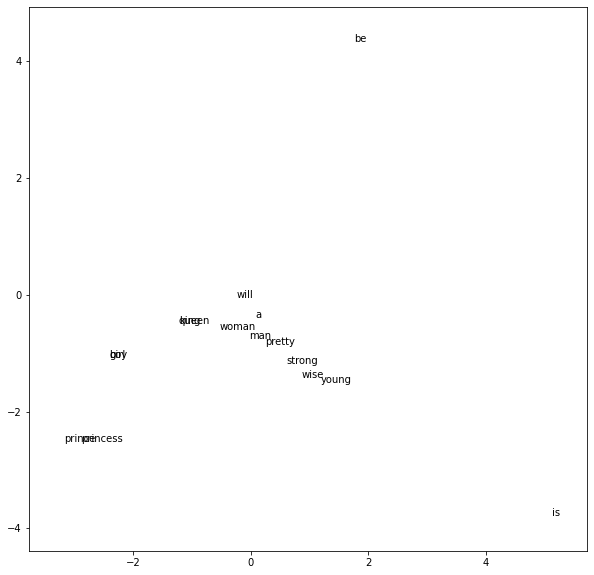

In [72]:
#将二维词向量可视化可以更直观看出w2v模型的分类效果
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word,x1,x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2))

PADDING = 0.6
x_axis_min = np.amin(vectors, axis = 0)[0] - PADDING
y_axis_min = np.amin(vectors, axis = 0)[1] - PADDING
x_axis_max = np.amax(vectors, axis = 0)[0] + PADDING
y_axis_max = np.amax(vectors, axis = 0)[1] + PADDING
plt.xlim(x_axis_min, x_axis_max)
plt.ylim(y_axis_min, y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)
plt.show()